In [1]:
from collections import Counter

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
import seaborn as sns
import scipy.stats
from sklearn.metrics import f1_score
import xgboost as xgb
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score, train_test_split

# Data exploration

In [2]:
df = pd.read_csv('Balazs_Varga/ephys_data/Global dataset with epsps_APs_040823BV_ready.csv', sep='\t')

In [3]:
labels = ['Unnamed: 1', 'cell number', 'cat  no', 'cell id', 'cell line', 'clone','TTX', 'condition', 'dpp']
df[labels]

Unnamed: 1  cell number  cat  no cell id cell line  clone  TTX  \
0        509_cell1_LV          509       30   cell1        LV      0    0   
1        509_cell2_LV          509       32   cell2        LV      0    0   
2        509_cell3_LV          509       35   cell3        LV      0    0   
3        509_cell4_LV          509      493   cell4        LV      0    0   
4        509_cell5_LV          509       36   cell5        LV      0    0   
..                ...          ...      ...     ...       ...    ...  ...   
568  2709709_cell1_LV      2709709      375   cell1        LV      0    0   
569  2709709_cell3_LV      2709709      377   cell3        LV      0    0   
570  2709709_cell4_LV      2709709      379   cell4        LV      0    0   
571  2709709_cell8_LV      2709709      382   cell8        LV      0    0   
572  2709709_cell8_LV      2709709      383   cell8        LV      0    0   

    condition  dpp  
0         con    7  
1         con    7  
2         con    7  
3         con    7  
4         con    7  
..        ...  ...  
568       con   29  
569       con   29  
570       con   29  
571       con   29  
572       con   29  

[573 rows x 9 columns]

In [4]:
l = []
for label in labels:
    l.append([label, len(df[label].value_counts())])

Text(0.5, 1.0, 'Different classes per label')

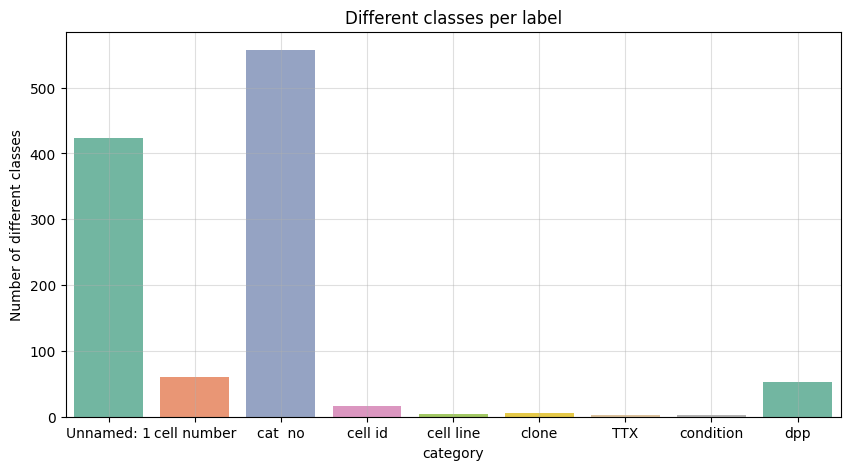

In [5]:
plt.figure(figsize=(10, 5))
plot = pd.DataFrame(l, columns=['category', 'n'])
sns.barplot(data=plot, x='category', y='n', palette='Set2')
plt.ylabel('Number of different classes')
plt.grid(alpha=0.4)
plt.title('Different classes per label')

Text(0.5, 1.0, 'Different classes per label')

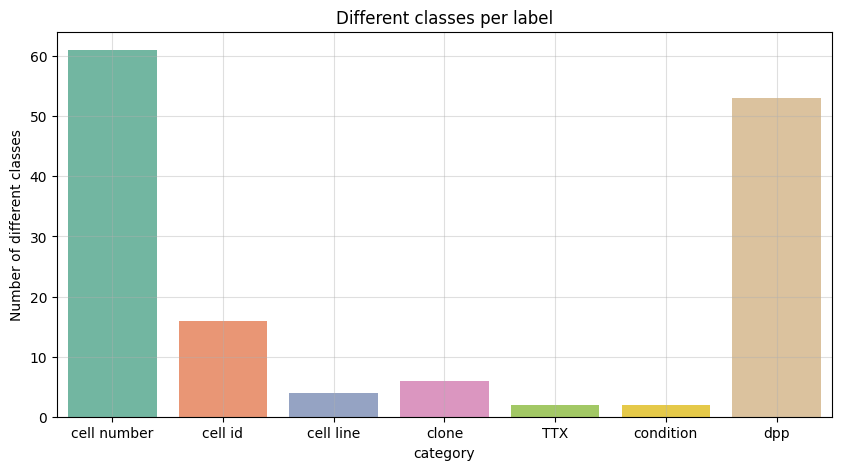

In [6]:
plt.figure(figsize=(10, 5))
plot = pd.DataFrame(l, columns=['category', 'n'])
plot = plot.query('category != "Unnamed: 1" & category != "cat  no"')
sns.barplot(data=plot, x='category', y='n', palette='Set2')
plt.ylabel('Number of different classes')
plt.grid(alpha=0.4)
plt.title('Different classes per label')

In [7]:
df[['TTX', 'condition']].value_counts().reset_index()

TTX condition    0
0    0        cc  308
1    0       con  247
2    1       con   11
3    1        cc    7

<Axes: >

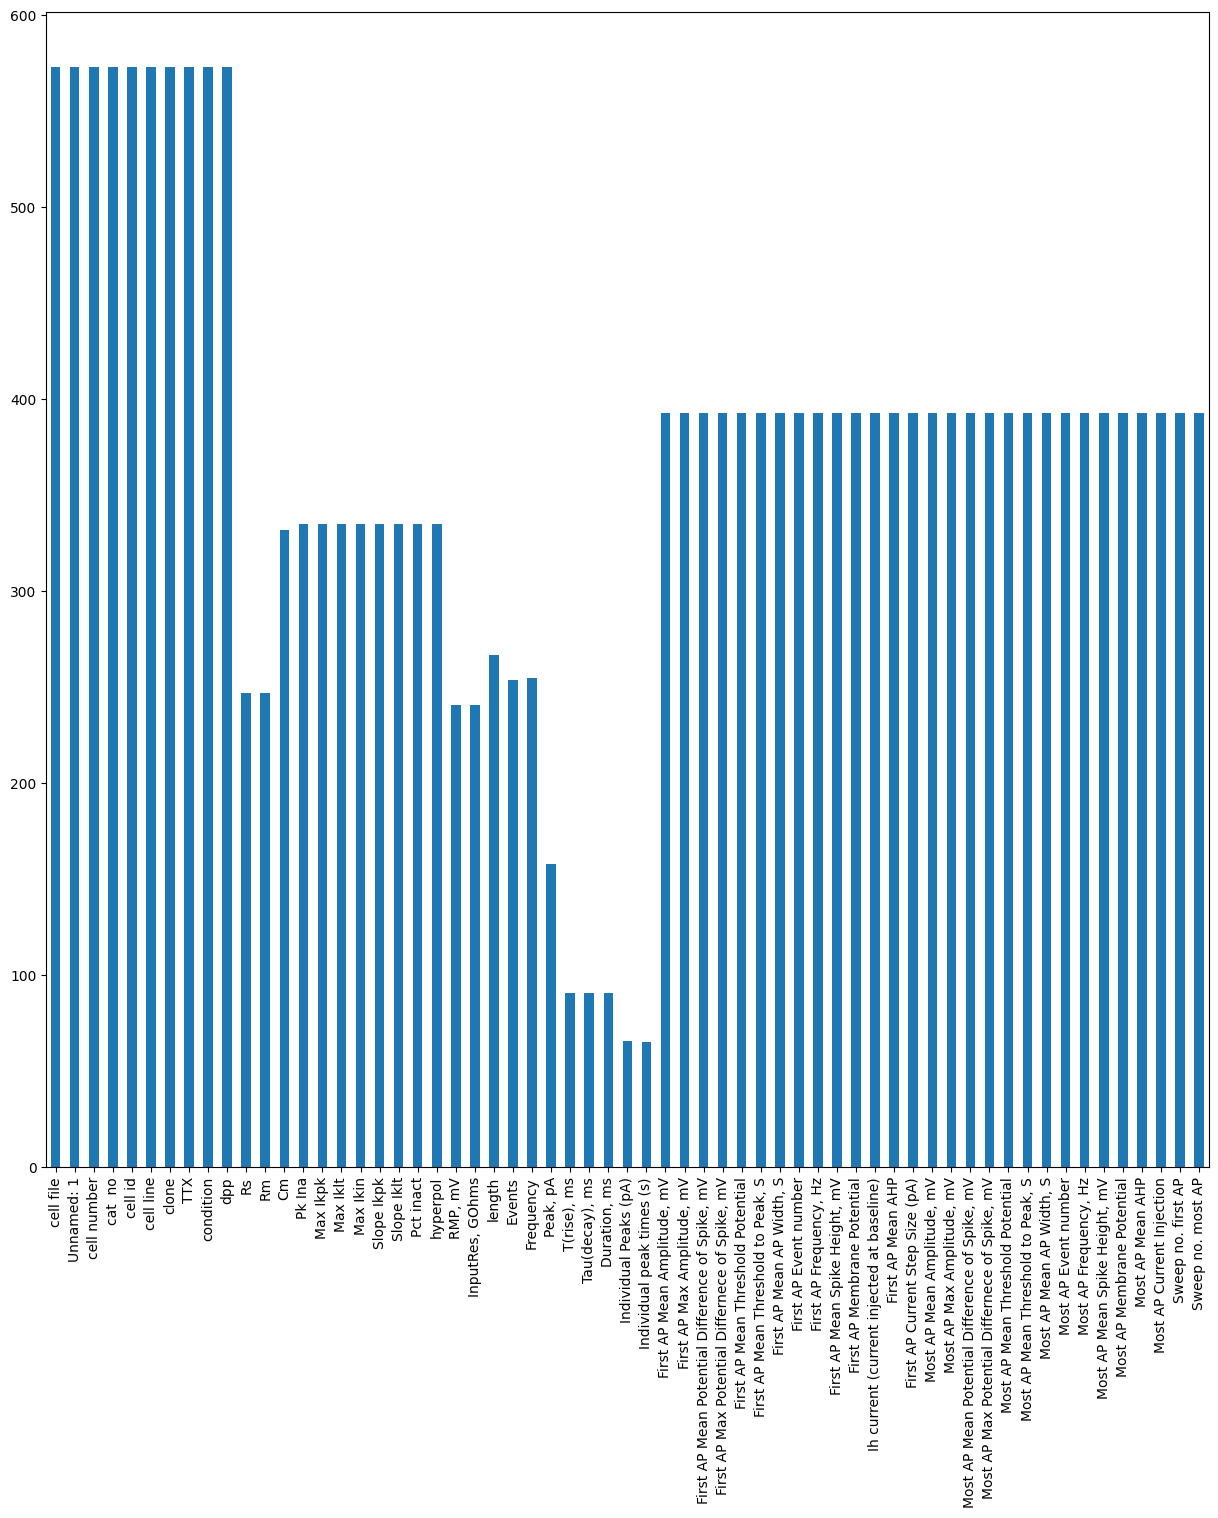

In [8]:
plt.figure(figsize=(15, 15))
(~df.isna()).sum().plot(kind='bar', orientation='vertical')

In [9]:
l1 = ['First AP Max Amplitude, mV',
       'First AP Mean Potential Difference of Spike, mV',
       'First AP Max Potential Differnece of Spike, mV',
       'First AP Mean Threshold Potential',
       'First AP Mean Threshold to Peak, S', 'First AP Mean AP Width, S',
       'First AP Event number', 'First AP Frequency, Hz',
       'First AP Mean Spike Height, mV', 'First AP Membrane Potential',
       'Ih current (current injected at baseline)', 'First AP Mean AHP',
       'First AP Current Step Size (pA)', 'Most AP Mean Amplitude, mV',
       'Most AP Max Amplitude, mV',
       'Most AP Mean Potential Difference of Spike, mV',
       'Most AP Max Potential Differnece of Spike, mV',
       'Most AP Mean Threshold Potential', 'Most AP Mean Threshold to Peak, S',
       'Most AP Mean AP Width, S', 'Most AP Event number',
       'Most AP Frequency, Hz', 'Most AP Mean Spike Height, mV',
       'Most AP Membrane Potential', 'Most AP Mean AHP',
       'Most AP Current Injection', 'Sweep no. first AP', 'Sweep no. most AP']

df['l1_is_na'] = df[l1].isna().all(axis=1)

In [10]:
l2 = ['Pk Ina', 'Max Ikpk', 'Max Iklt', 'Max Ikin', 'Slope Ikpk',
       'Slope Iklt', 'Pct inact', 'hyperpol']

In [11]:
df['l2_is_na'] = df[l2].isna().any(axis=1)

In [12]:
l1_indices = set(df.query('l1_is_na == False').index)
l2_indices = set(df.query('l2_is_na == False').index)

Text(0.5, 1.0, 'Number of present elements from L1 and L2')

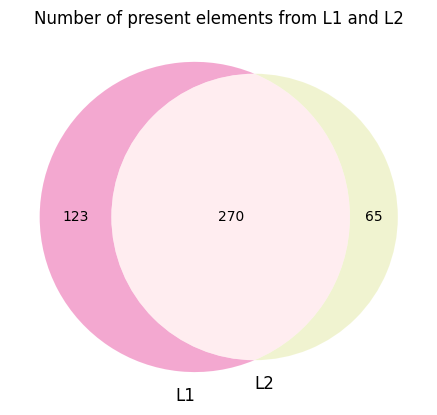

In [13]:
venn2(subsets = (len(l1_indices - l2_indices), len(l2_indices - l1_indices), len(l1_indices.intersection(l2_indices))),
  set_labels = ('L1', 
                'L2'),
  set_colors=("#e953a2",
              "#e3e9a2"),alpha=0.5)

plt.title('Number of present elements from L1 and L2')

In [14]:
um = [
    ['Entire dataset', len(df)],
    ['L1 + L2', 270],
    ['Small dataset', 45]
]

In [15]:
df['cell line'].value_counts()

192    220
14     162
LV     138
16      53
Name: cell line, dtype: int64

In [16]:
df[['cell line', 'clone']].value_counts()

cell line  clone
192        4        184
LV         0        138
14         3         84
           5         78
16         2         53
192        7         36
dtype: int64

In [17]:
df['TTX'].value_counts()

0    555
1     18
Name: TTX, dtype: int64

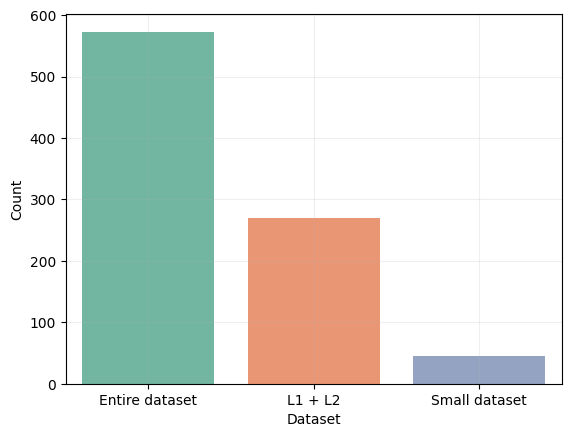

In [18]:
um_df = pd.DataFrame(um, columns=['Dataset', 'Count'])
sns.barplot(um_df, x='Dataset', y='Count', palette='Set2')
plt.grid(alpha=0.2)

# Data binning

In [19]:
df['A'] = df['dpp'].apply(lambda x: 
                0 if x in (range(0,15))
                else 1 if x in range(15,29)
                else 2 if x in range(29,43)
                else 3 if x in range(43,57)
                else 4)
df['B'] = df['dpp'].apply(lambda x: 
                0 if x in (range(0, 22))
                else 1 if x in range(22,36)
                else 2 if x in range(36,50)
                else 3 if x in range(50,64)
                else 4)
df['C'] = df['dpp'].apply(lambda x: 
                0 if x in (range(0,29))
                else 1)
df['D'] = df['dpp'].apply(lambda x: 
                0 if x in (range(0,36))
                else 1)
                                                                        

In [20]:
df_subset = df.query('l1_is_na == False & l2_is_na == False')

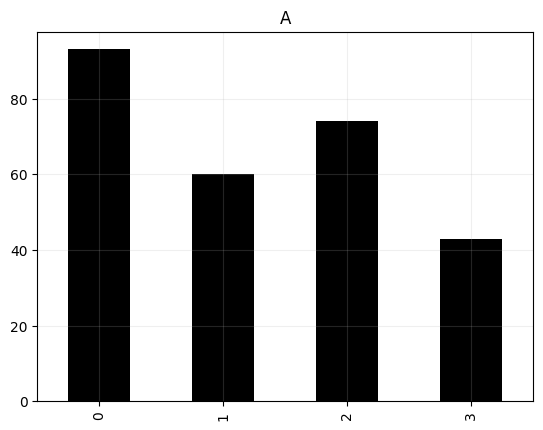

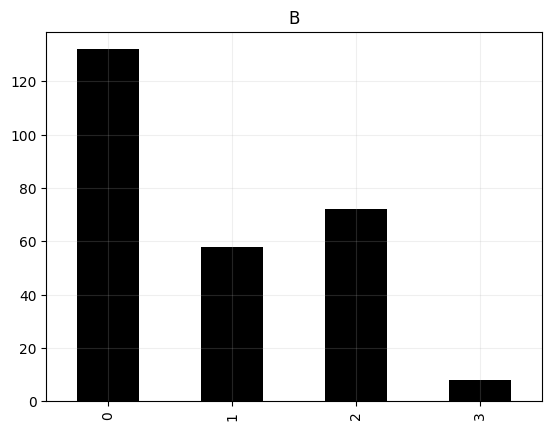

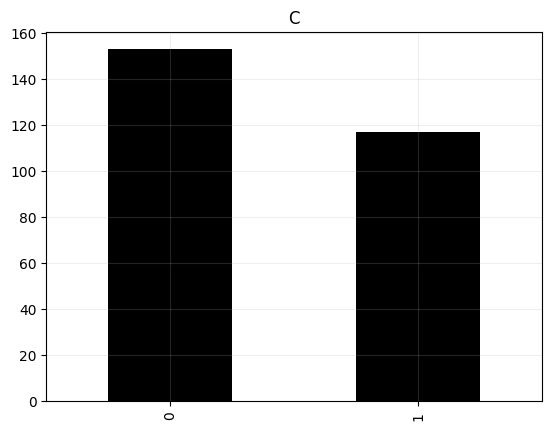

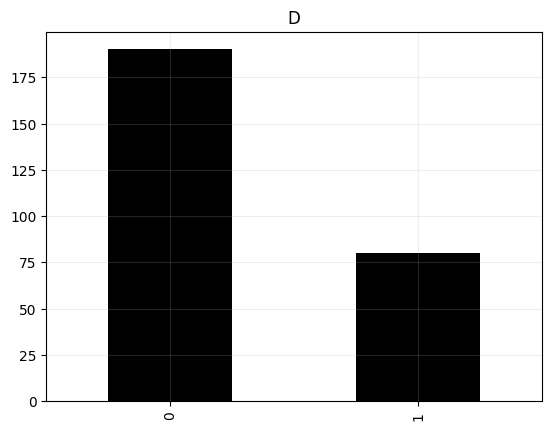

In [21]:
for label in ['A', 'B', 'C', 'D']:
    df_subset[label].value_counts(sort=False).plot(kind='bar', color='black')
    plt.grid(alpha=0.2)
    plt.title(label)
    plt.show()

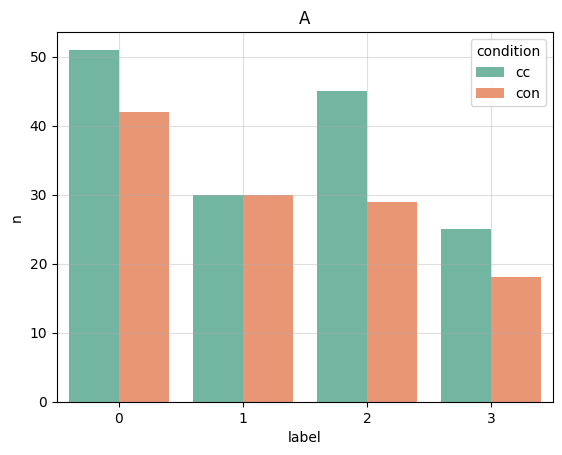

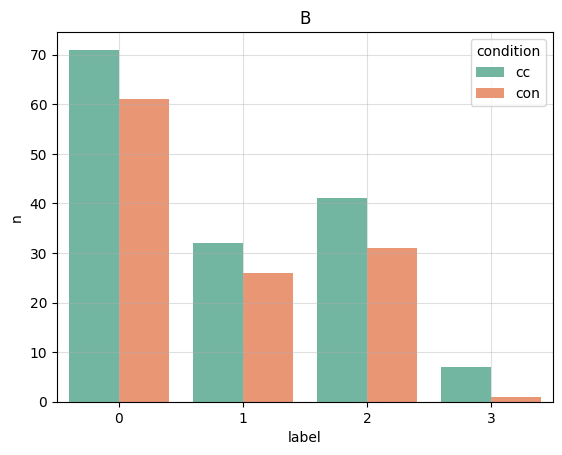

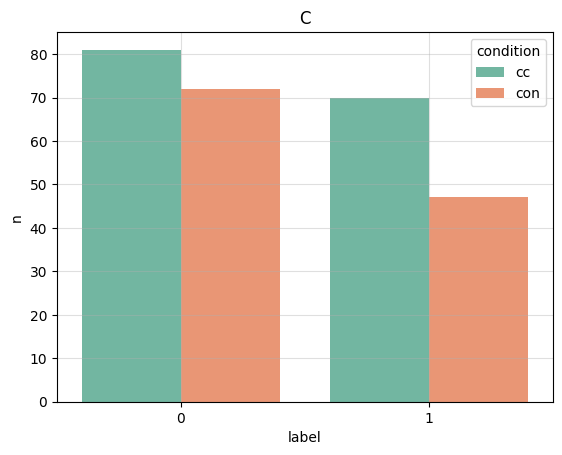

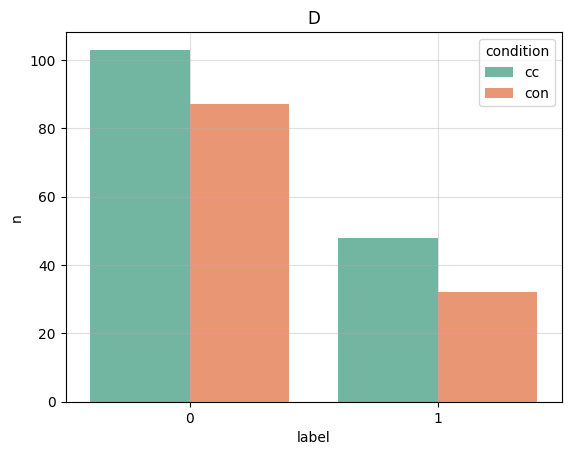

In [22]:
for label in ['A', 'B', 'C', 'D']:
    x = pd.DataFrame(df_subset.groupby([label])['condition'].value_counts())
    x.columns = ['n']
    temp_df = x.reset_index()
    temp_df.columns = ['label', 'condition', 'n']
    sns.barplot(data=temp_df, x='label', hue='condition', y='n', palette='Set2')
    plt.title(label)
    plt.grid(alpha=0.4)
    plt.show()

<Axes: xlabel='dpp', ylabel='Count'>

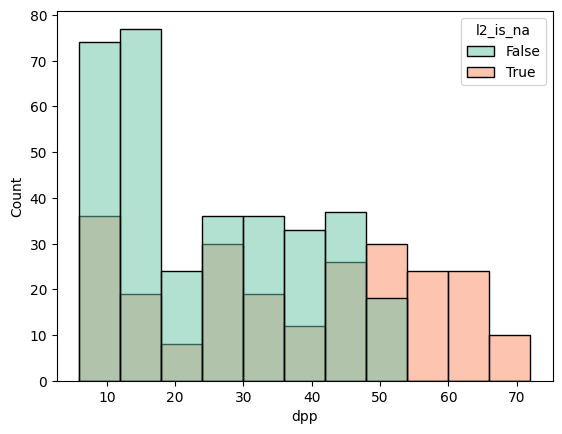

In [23]:
sns.histplot(data=df, x='dpp', hue='l2_is_na', palette='Set2')

Text(0.5, 1.0, 'Days in L1+L2 dataset')

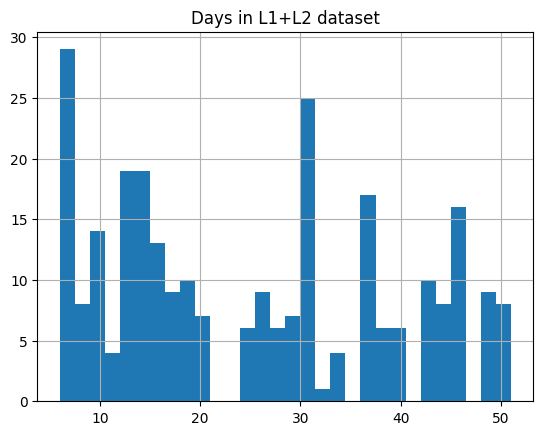

In [24]:
df_subset['dpp'].hist(bins=30)
plt.title('Days in L1+L2 dataset')

In [25]:
df_subset['condition'].value_counts()

cc     151
con    119
Name: condition, dtype: int64

# Initial predictions

In [27]:
model = RandomForestClassifier(class_weight='balanced')

In [28]:
df['label_cond'] = df['condition'] == 'cc'
df_subset['label_cond'] = df_subset['condition'] == 'cc'

/tmp/ipykernel_321675/3610326688.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset['label_cond'] = df_subset['condition'] == 'cc'


In [29]:
cross_val_score(model, df_subset[l1 + l2], df_subset['label_cond'], cv=5, scoring='accuracy').mean()

0.5888888888888889

In [30]:
sub_normalised = pd.read_csv('Balazs_Varga/ephys_data/ss3_part2_feature_selection_try2_logistic/minmax_norm_45samples_40features.csv',index_col=0)
df_label =pd.read_csv('Balazs_Varga/ephys_data/ss3_part2_feature_selection_try2_logistic/y_label_45samples.csv',index_col=0)
df_label['condition'] = df_label['condition'] == 'cc'

In [31]:
X_train, X_test, y_train, y_test = train_test_split(sub_normalised, df_label.condition.to_list(), 
                                                    test_size=0.2, 
                                                    random_state=0,
                                                    stratify=df_label.condition.to_list())

In [33]:
xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=2)

In [34]:
df_subset[df_subset['B'] == 3]

cell file       Unnamed: 1  cell number  cat  no cell id  \
209   230118_cell1_cc_0002.abf  230118_cell1_14       230118      363   cell1   
210   230118_cell2_cc_0001.abf  230118_cell2_14       230118      364   cell2   
211   230118_cell3_cc_0001.abf  230118_cell3_14       230118      365   cell3   
213   230118_cell5_cc_0001.abf  230118_cell5_14       230118      367   cell5   
214   230118_cell6_cc_0002.abf  230118_cell6_14       230118      369   cell6   
215   230118_cell7_cc_0001.abf  230118_cell7_14       230118      370   cell7   
216   230118_cell8_cc_0001.abf  230118_cell8_14       230118      371   cell8   
217  240118_cell1_con_0002.abf  240118_cell1_14       240118      372   cell1   

    cell line  clone  TTX condition  dpp  ...  Most AP Current Injection  \
209        14      3    0        cc   50  ...                  31.182430   
210        14      3    0        cc   50  ...                  48.937031   
211        14      3    0        cc   50  ...                  49.071948   
213        14      3    0        cc   50  ...                 151.286566   
214        14      3    0        cc   50  ...                  24.975085   
215        14      3    0        cc   50  ...                  18.763742   
216        14      3    0        cc   50  ...                  43.048313   
217        14      3    0       con   51  ...                  12.975779   

     Sweep no. first AP  Sweep no. most AP  l1_is_na  l2_is_na  A  B  C  D  \
209                 6.0                6.0     False     False  3  3  1  1   
210                 3.0                9.0     False     False  3  3  1  1   
211                 9.0                9.0     False     False  3  3  1  1   
213                 6.0               26.0     False     False  3  3  1  1   
214                 5.0                5.0     False     False  3  3  1  1   
215                 4.0                4.0     False     False  3  3  1  1   
216                 4.0                8.0     False     False  3  3  1  1   
217                 3.0                3.0     False     False  3  3  1  1   

     label_cond  
209        True  
210        True  
211        True  
213        True  
214        True  
215        True  
216        True  
217       False  

[8 rows x 68 columns]

In [35]:
params= {
    'objective':'binary:logistic',
    'eval_metric': 'auc',
}

/home/lp488/.local/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:13] WARNING: /workspace/src/metric/auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
/home/lp488/.local/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:14] WARNING: /workspace/src/metric/auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
/home/lp488/.local/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:15] WARNING: /workspace/src/metric/auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
/home/lp488/.local/lib/python3.9/site-packages/xgboost/core.py:160: UserWarning: [10:48:16] WARNING: /workspace/src/metric/auc.cc:320: Dataset is empty, or contains only positive or negative samples.
  warnings.warn(smsg, UserWarning)
/home/lp488/.local/lib/python3.9/site-packages/xgboost/core.

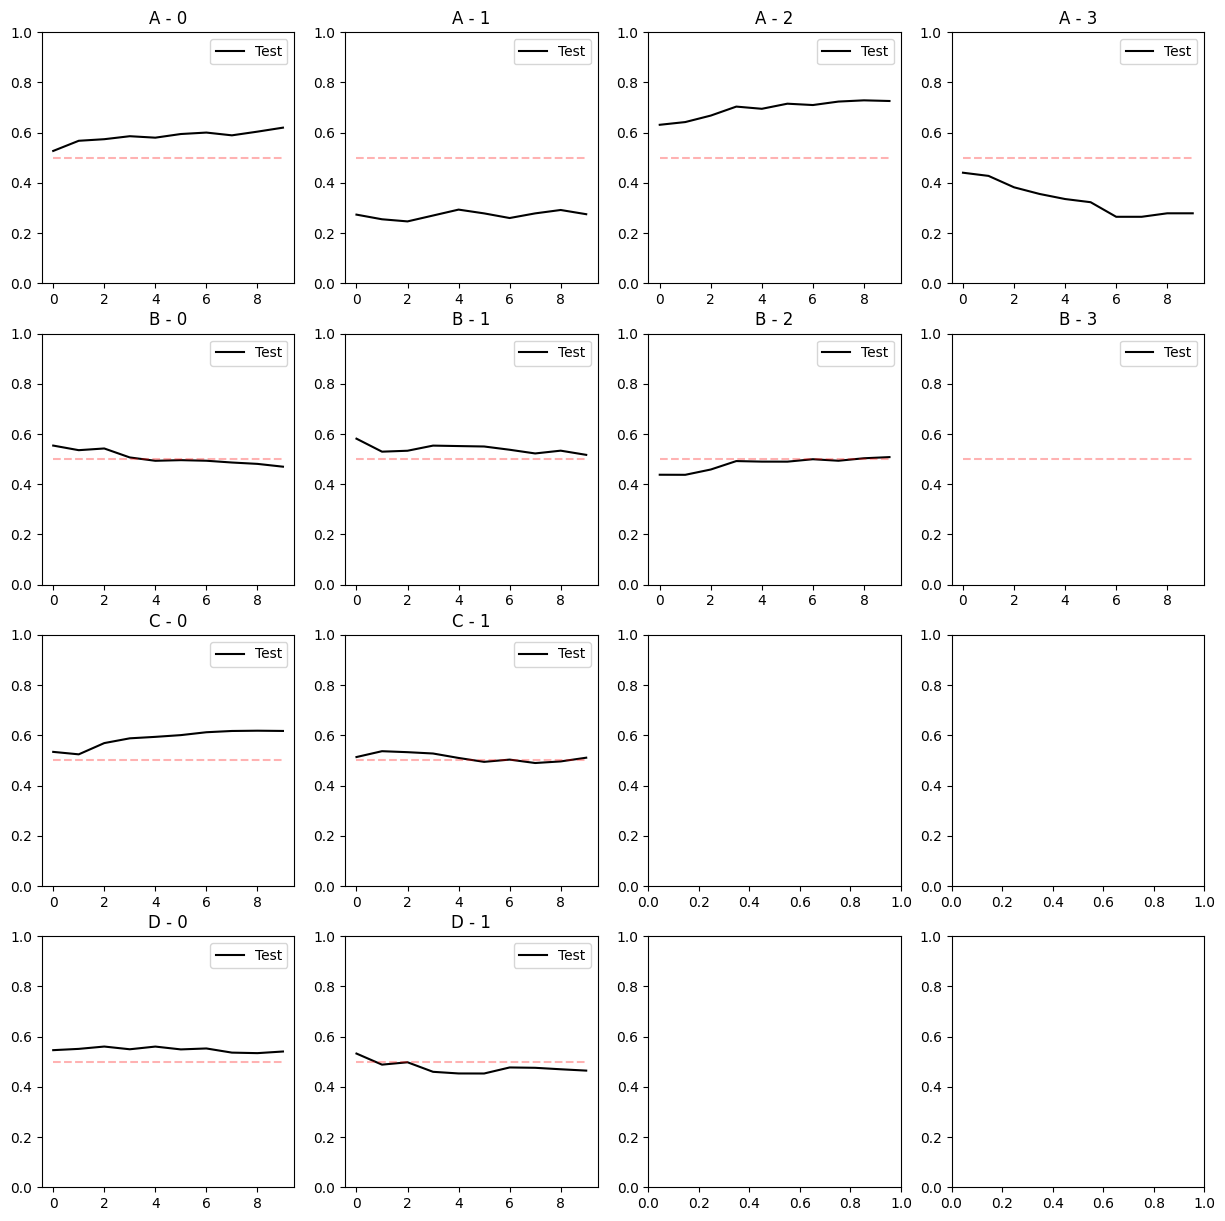

In [36]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(15, 15))
for row, label in enumerate(['A', 'B', 'C', 'D']):
    for col, timepoint in enumerate(list(df_subset[label].value_counts(sort=False).index)):
        ax = axes[row][col]
        
        temp_df = df_subset[df_subset[label] == timepoint]
        data_dmatrix_mine = xgb.DMatrix(data=temp_df[l1 + l2], label=temp_df['label_cond'])
        scores_mine = xgb.cv(dtrain=data_dmatrix_mine, params=params)#,  stratified=True)
        ax.plot(scores_mine['test-auc-mean'], label='Test'.format(label, timepoint), color='black')
        #ax.plot(scores_mine['train-auc-mean'], label='train'.format(label, timepoint), color='black')
        ax.legend()
        ax.set_title('{} - {}'.format(label, timepoint))
        ax.set_ylim(0, 1)
        ax.plot(range(10), [0.5] * 10, alpha=0.3, color='red', linestyle='dashed')
        #xgb_model = xgb.XGBClassifier(n_estimators=100, max_depth=2)
        #bst = xgb.train(dtrain=data_dmatrix_mine, params=params, num_boost_round=50)
        #plot_importance(bst, ax=axes[row][col*2+1])
plt.show()

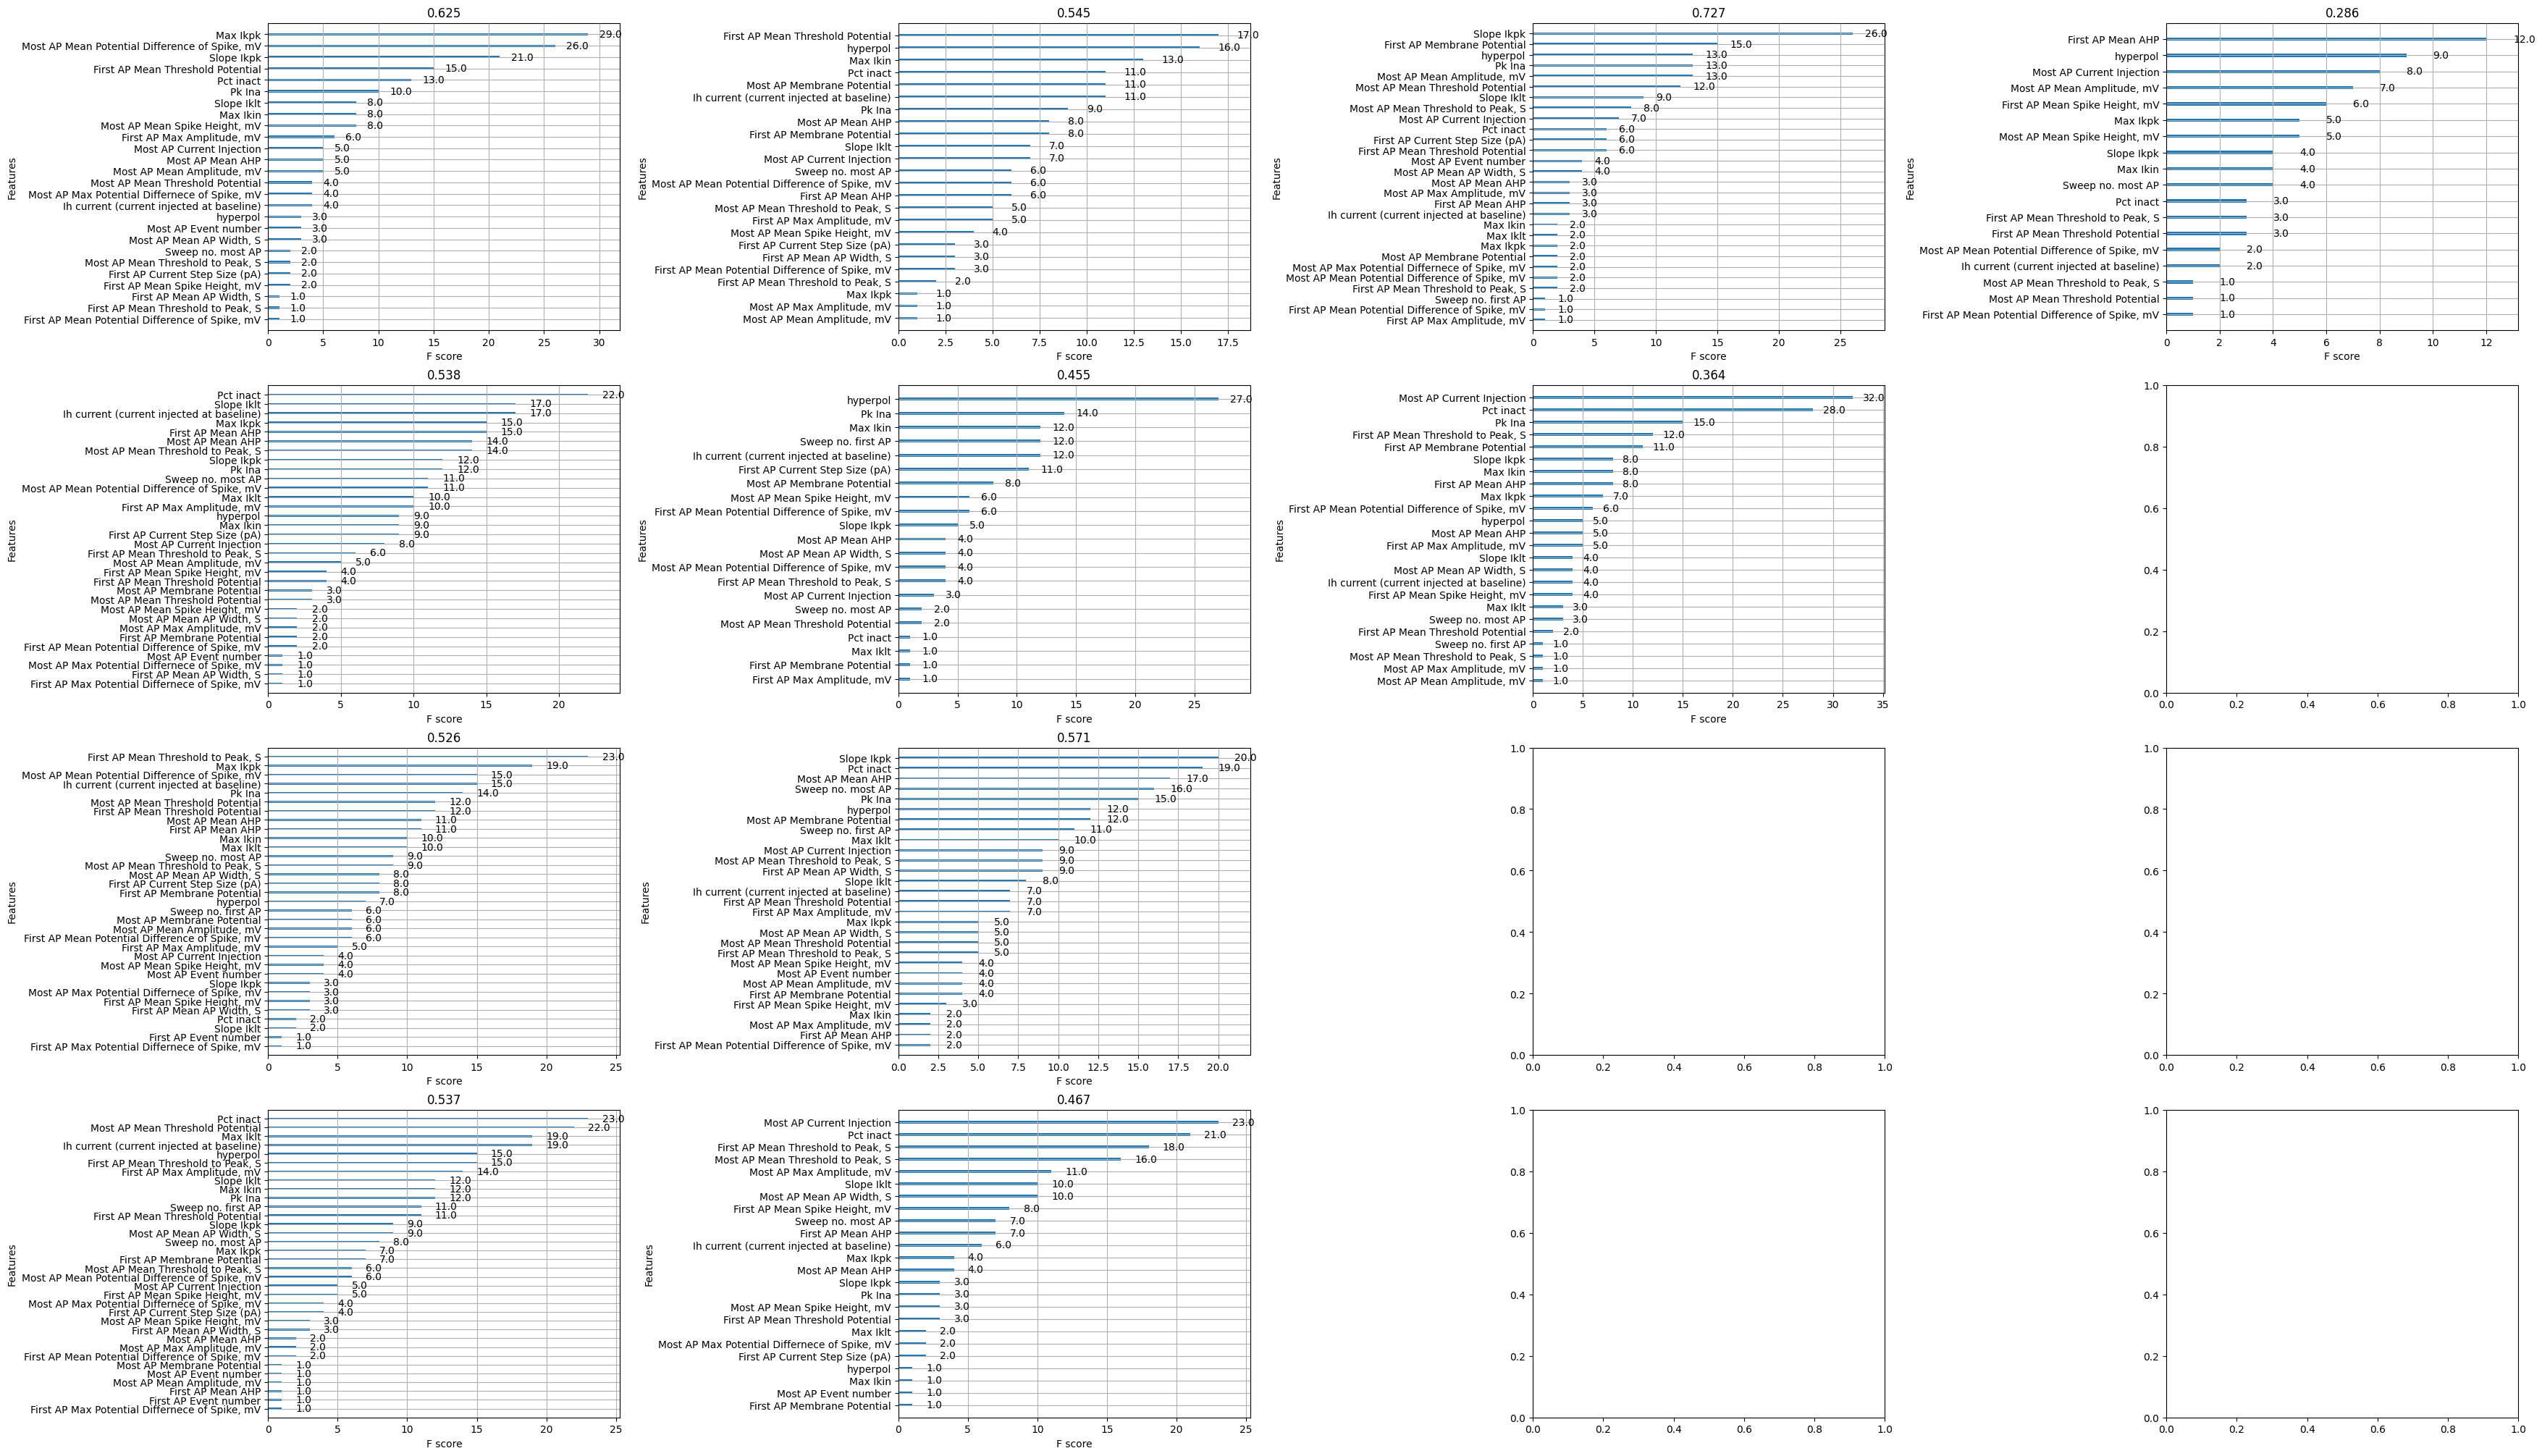

In [38]:
fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(35, 20), constrained_layout=True)
for row, label in enumerate(['A', 'B', 'C', 'D']):
    for col, timepoint in enumerate(list(df_subset[label].value_counts(sort=False).index)):
        ax = axes[row][col]
        
        temp_df = df_subset[df_subset[label] == timepoint]
        X_train, X_test, y_train, y_test = train_test_split(temp_df[l1 + l2], temp_df['label_cond'],
                                                            test_size=0.33, random_state=7)
        dmatrix_train = xgb.DMatrix(data=X_train, label=y_train)
        dmatrix_test = xgb.DMatrix(data=X_test, label=y_test)
        model = xgb.XGBClassifier(n_estimators=100, max_depth=2)
        model.fit(X_train, y_train)
        # make predictions for test data
        y_pred = model.predict(X_test)
        predictions = [round(value) for value in y_pred]
        # evaluate predictions
        f1score = f1_score(y_test, predictions)
        #scores_mine = xgb.cv(dtrain=data_dmatrix_mine, params=params)#,  stratified=True)
        #ax.plot(scores_mine['test-auc-mean'], label='{} - {}'.format(label, timepoint))
        #ax.legend()
        #ax.set_ylim(0, 1)

        #bst = xgb.train(dtrain=data_dmatrix_mine, params=params, num_boost_round=50)
        if row == 1 and col == 3:
            continue
        plot_importance(model, ax=axes[row][col])
        ax.set_title(round(f1score, 3))
plt.show()

# Standard deviation analysis

In [39]:
subset_features = [
    'Most AP Max Potential Differnece of Spike, mV',
    'Most AP Mean Amplitude, mV',
    'Most AP Mean Threshold Potential',
    'First AP Mean Threshold Potential',
    'Max Ikpk',
    'hyperpol',
    'Pk Ina',
    'Slope Ikpk',
    'Pct inact',
    'Most AP Mean Spike Height, mV',
    'Most AP Mean Threshold to Peak, S',
]

In [40]:
df.groupby('A')[subset_features].std().T.drop(4, axis=1)

A                                                        0            1  \
Most AP Max Potential Differnece of Spike, mV    13.803003    15.194966   
Most AP Mean Amplitude, mV                       21.547784    24.821519   
Most AP Mean Threshold Potential                  9.710798    15.633829   
First AP Mean Threshold Potential                11.273093    17.098912   
Max Ikpk                                       1242.945030  1285.816111   
hyperpol                                         31.745976    50.073724   
Pk Ina                                         1348.417411  1162.361247   
Slope Ikpk                                      159.709247   163.172918   
Pct inact                                        10.671605    11.464763   
Most AP Mean Spike Height, mV                    18.701880    22.665383   
Most AP Mean Threshold to Peak, S                 0.002002     0.003687   

A                                                        2            3  
Most AP Max Potential Differnece of Spike, mV    19.268589    18.231086  
Most AP Mean Amplitude, mV                       23.305872    23.485058  
Most AP Mean Threshold Potential                 10.804513    18.338816  
First AP Mean Threshold Potential                11.604154    19.711425  
Max Ikpk                                       1682.342639  1587.909107  
hyperpol                                         47.297961    35.171294  
Pk Ina                                         1760.025297  1613.300155  
Slope Ikpk                                      179.155221   193.996288  
Pct inact                                        10.836739    14.288589  
Most AP Mean Spike Height, mV                    17.800427    19.759214  
Most AP Mean Threshold to Peak, S                 0.002485     0.002366

In [41]:
std_df = df.groupby('A')[subset_features].std().T.drop(4, axis=1)
std_df = std_df.div(std_df.sum(axis=1), axis=0).reset_index()

In [42]:
std_df_melted = pd.melt(std_df, value_vars=[0, 1, 2, 3], id_vars=['index'])

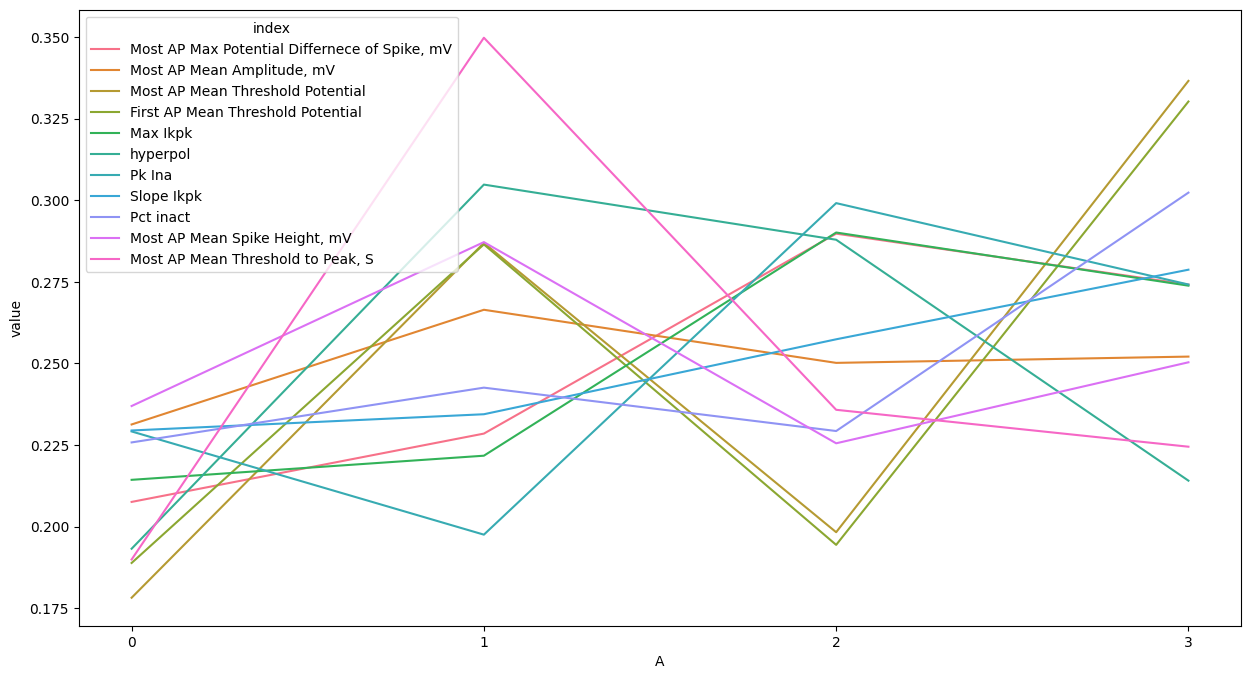

In [43]:
plt.figure(figsize=(15, 8))
sns.lineplot(data=std_df_melted, x='A', y='value', hue='index')
plt.xticks(range(4));

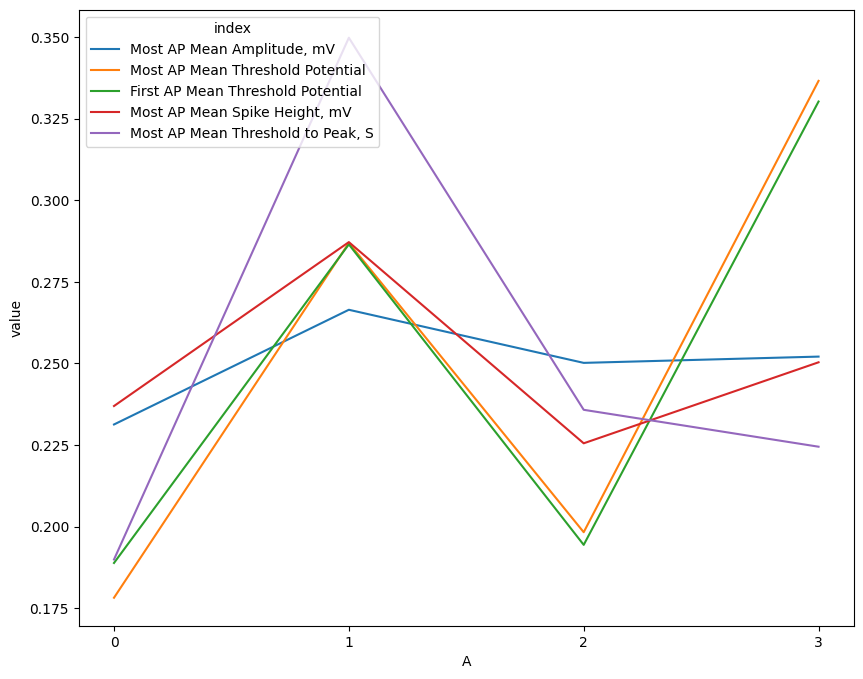

In [44]:
plt.figure(figsize=(10, 8))
set1 = ['Most AP Mean Amplitude, mV', 'Most AP Mean Threshold to Peak, S', 'Most AP Mean Spike Height, mV',
        'Most AP Mean Threshold Potential', 'First AP Mean Threshold Potential']
sns.lineplot(data=std_df_melted.query('index == @set1'), x='A', y='value', hue='index')
plt.xticks(range(4));

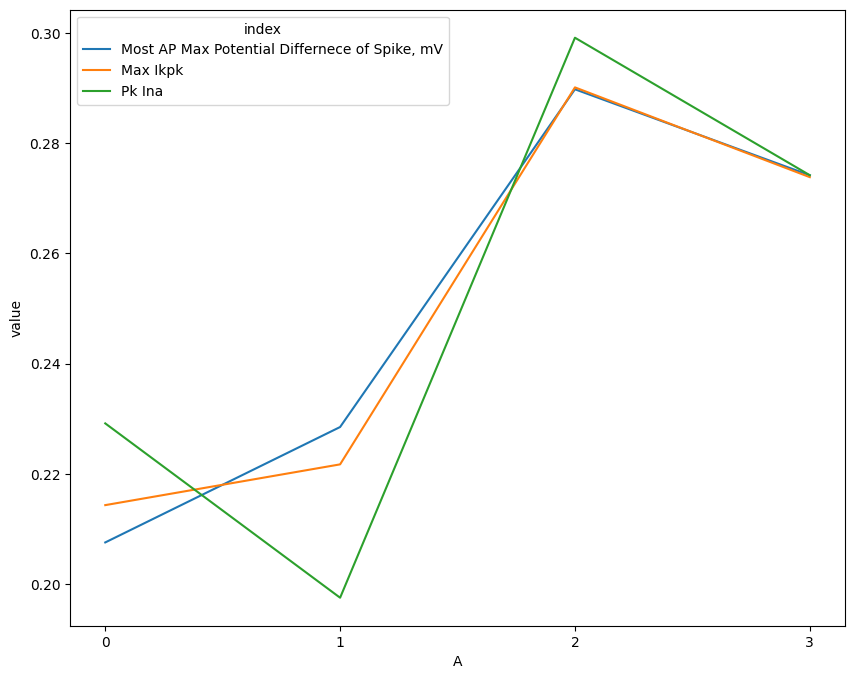

In [45]:
plt.figure(figsize=(10, 8))
set2 = ['Most AP Max Potential Differnece of Spike, mV', 'Pk Ina', 'Max Ikpk']
sns.lineplot(data=std_df_melted.query('index == @set2'), x='A', y='value', hue='index')
plt.xticks(range(4));

<Axes: xlabel='index'>

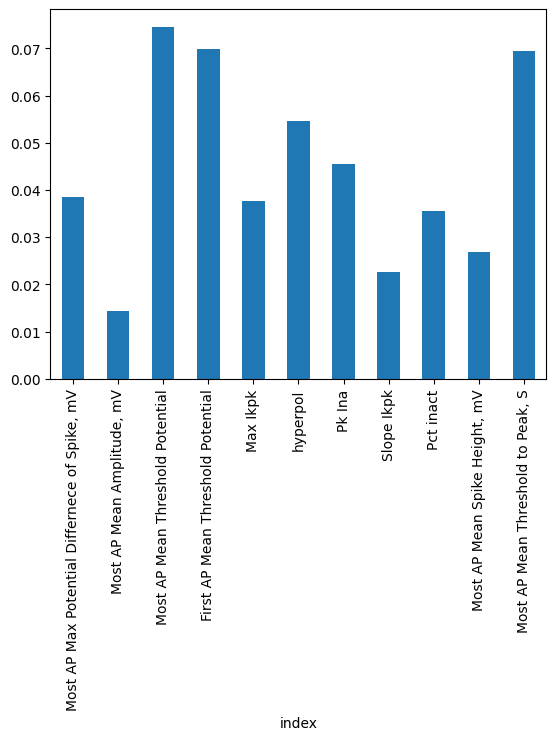

In [46]:
std_df.set_index('index').std(axis=1).plot(kind='bar')

Text(0.5, 1.0, 'Con')

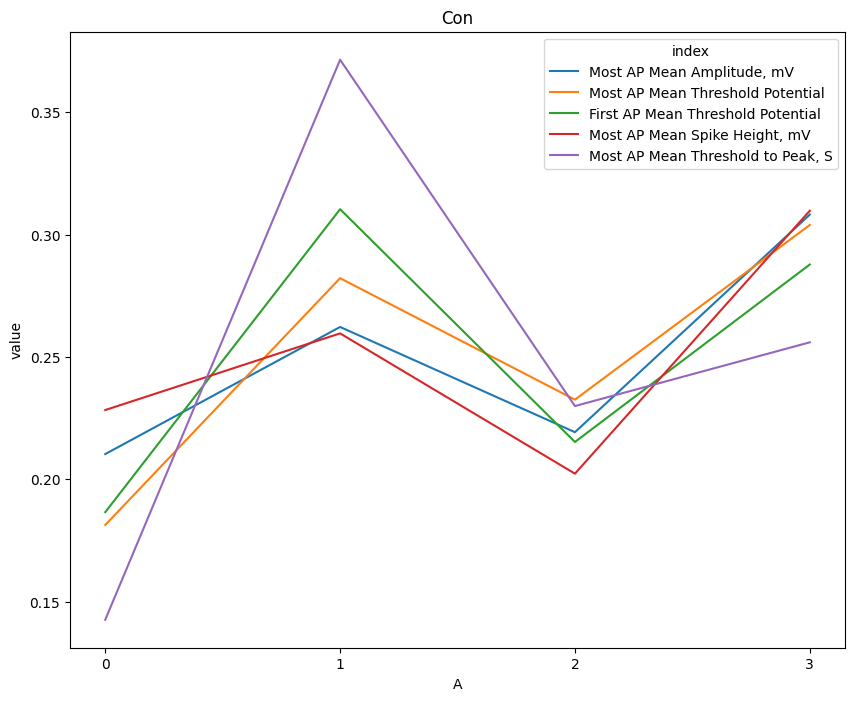

In [47]:
con_df = df.query('condition == "con"')
std_df = con_df.groupby('A')[subset_features].std().T.drop(4, axis=1)
std_df = std_df.div(std_df.sum(axis=1), axis=0).reset_index()
std_df_melted = pd.melt(std_df, value_vars=[0, 1, 2, 3], id_vars=['index'])
plt.figure(figsize=(10, 8))
set1 = ['Most AP Mean Amplitude, mV', 'Most AP Mean Threshold to Peak, S', 'Most AP Mean Spike Height, mV',
        'Most AP Mean Threshold Potential', 'First AP Mean Threshold Potential']
sns.lineplot(data=std_df_melted.query('index == @set1'), x='A', y='value', hue='index')
plt.xticks(range(4));
plt.title('Con')

Text(0.5, 1.0, 'CC')

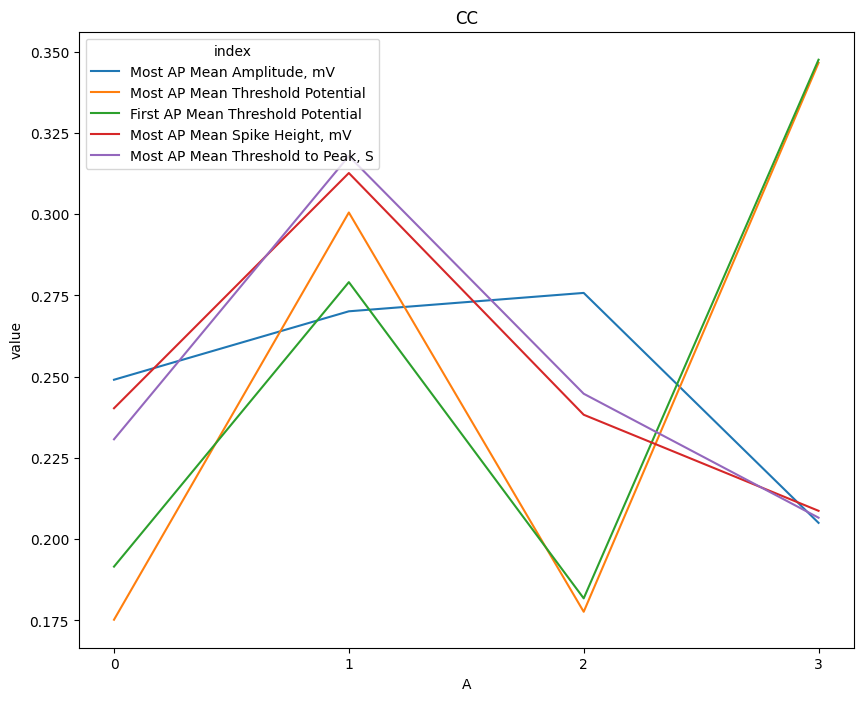

In [48]:
con_df = df.query('condition == "cc"')
std_df = con_df.groupby('A')[subset_features].std().T.drop(4, axis=1)
std_df = std_df.div(std_df.sum(axis=1), axis=0).reset_index()
std_df_melted = pd.melt(std_df, value_vars=[0, 1, 2, 3], id_vars=['index'])
plt.figure(figsize=(10, 8))
set1 = ['Most AP Mean Amplitude, mV', 'Most AP Mean Threshold to Peak, S', 'Most AP Mean Spike Height, mV',
        'Most AP Mean Threshold Potential', 'First AP Mean Threshold Potential']
sns.lineplot(data=std_df_melted.query('index == @set1'), x='A', y='value', hue='index')
plt.xticks(range(4));
plt.title('CC')

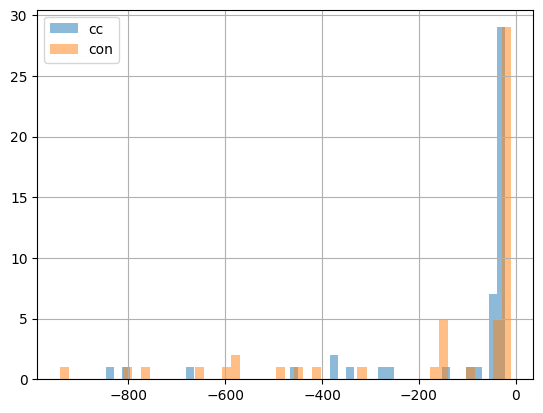

In [49]:
df.query('-1000 < `Peak, pA` < -20 & condition == "cc"')['Peak, pA'].hist(bins=50, alpha=0.5, label='cc')
df.query('-1000 < `Peak, pA` < -0 & condition == "con"')['Peak, pA'].hist(bins=50, alpha=0.5, label='con')
plt.legend()

Text(0.5, 1.0, 'CC')

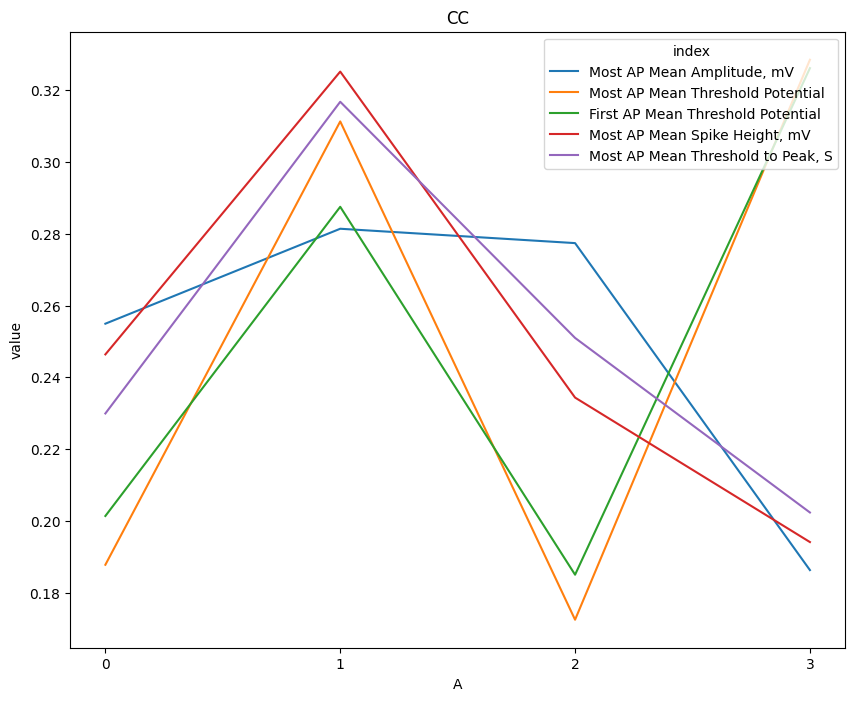

In [50]:
con_df = df.query('condition == "cc"')
std_df = (con_df.groupby('A')[subset_features].std() / con_df.groupby('A')[subset_features].mean()).T.drop(4, axis=1)
std_df = std_df.div(std_df.sum(axis=1), axis=0).reset_index()
std_df_melted = pd.melt(std_df, value_vars=[0, 1, 2, 3], id_vars=['index'])
plt.figure(figsize=(10, 8))
set1 = ['Most AP Mean Amplitude, mV', 'Most AP Mean Threshold to Peak, S', 'Most AP Mean Spike Height, mV',
        'Most AP Mean Threshold Potential', 'First AP Mean Threshold Potential']
sns.lineplot(data=std_df_melted.query('index == @set1'), x='A', y='value', hue='index')
plt.xticks(range(4));
plt.title('CC')

Text(0.5, 1.0, 'Con')

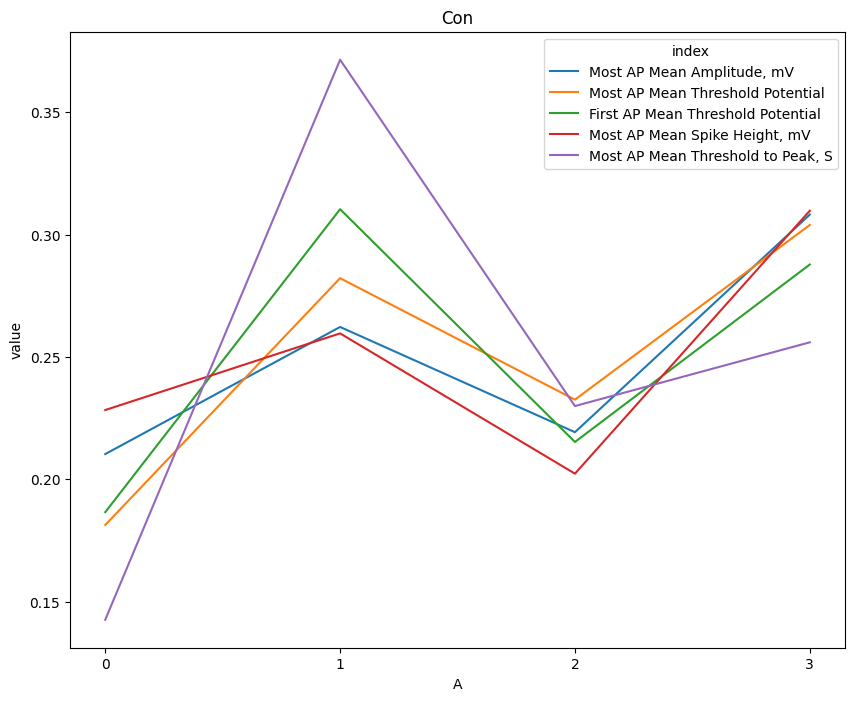

In [51]:
con_df = df.query('condition == "con"')
std_df = con_df.groupby('A')[subset_features].std().T.drop(4, axis=1)
std_df = std_df.div(std_df.sum(axis=1), axis=0).reset_index()
std_df_melted = pd.melt(std_df, value_vars=[0, 1, 2, 3], id_vars=['index'])
plt.figure(figsize=(10, 8))
set1 = ['Most AP Mean Amplitude, mV', 'Most AP Mean Threshold to Peak, S', 'Most AP Mean Spike Height, mV',
        'Most AP Mean Threshold Potential', 'First AP Mean Threshold Potential']
sns.lineplot(data=std_df_melted.query('index == @set1'), x='A', y='value', hue='index')
plt.xticks(range(4));
plt.title('Con')

In [52]:
std_df = df.groupby('A')[subset_features].std().T.drop(4, axis=1)
std_df = std_df.div(std_df.sum(axis=1), axis=0).reset_index()

In [53]:
bigger_std_df = df.groupby('A')[l1 + l2].std().T.drop(4, axis=1)
bigger_std_df = bigger_std_df.div(bigger_std_df.sum(axis=1), axis=0).reset_index()
bigger_std_to_plot = bigger_std_df.set_index('index').std(axis=1).sort_values(ascending=False).reset_index()
bigger_std_to_plot.columns = ['feature', 'val']

<Axes: xlabel='A', ylabel='value'>

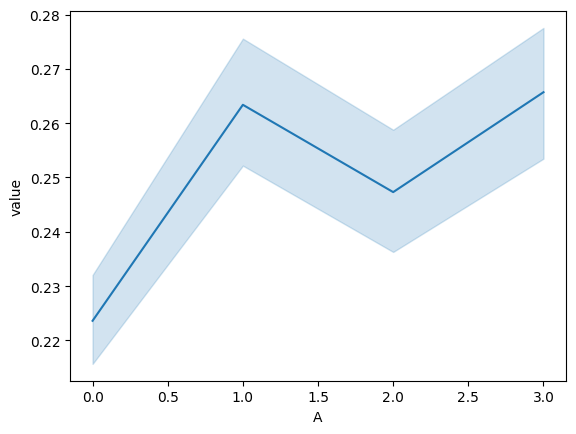

In [54]:
hm = df.groupby('A')[l1 + l2].std().T.drop(4, axis=1)
hm = hm.div(hm.sum(axis=1), axis=0).reset_index()
hm = pd.melt(hm, value_vars=[0, 1, 2, 3], id_vars=['index'] )
sns.lineplot(data=hm, x='A', y='value')


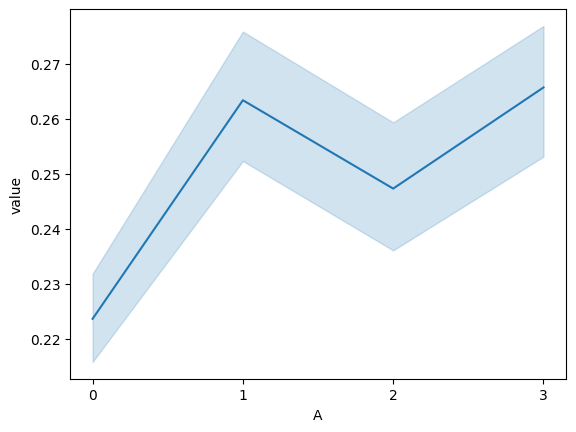

In [55]:
hm = df.groupby('A')[l1+l2].std().T.drop(4, axis=1)
hm = hm.div(hm.sum(axis=1), axis=0).reset_index()
hm = pd.melt(hm, value_vars=[0, 1, 2, 3], id_vars=['index'] )
sns.lineplot(data=hm, x='A', y='value')
plt.xticks(range(4));

In [56]:
colors = ['black' if i not in subset_features else 'red' for i in bigger_std_to_plot['feature'].values]

<Axes: xlabel='val', ylabel='feature'>

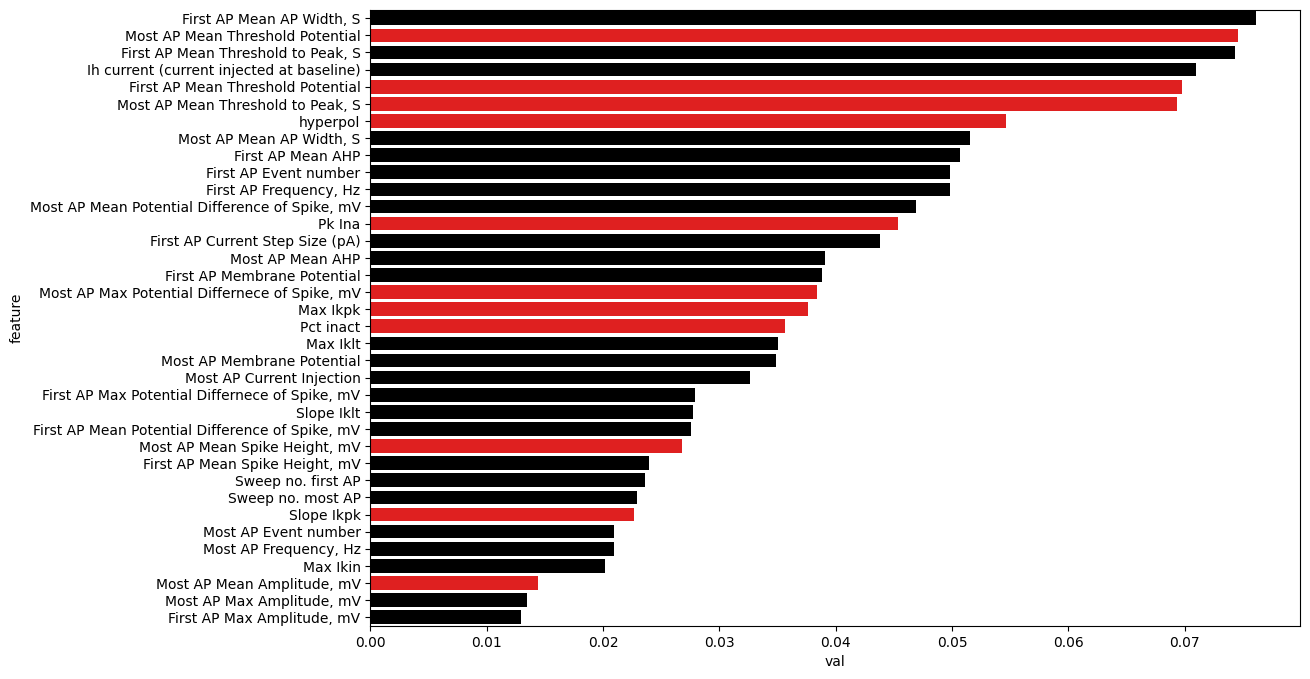

In [57]:
plt.figure(figsize=(12, 8))
sns.barplot(data=bigger_std_to_plot, y='feature', x='val', palette=sns.color_palette(colors))

In [58]:
subset1 = ['Max lkpk', 'Mo']

In [59]:
df['coef_var_l1l2'] = df[l1+l2].std(axis=1) / df[l1+l2].mean(axis=1)

In [60]:
df['std_l1l2'] = df[l1+l2].std(axis=1)

Text(0.5, 1.0, 'CC')

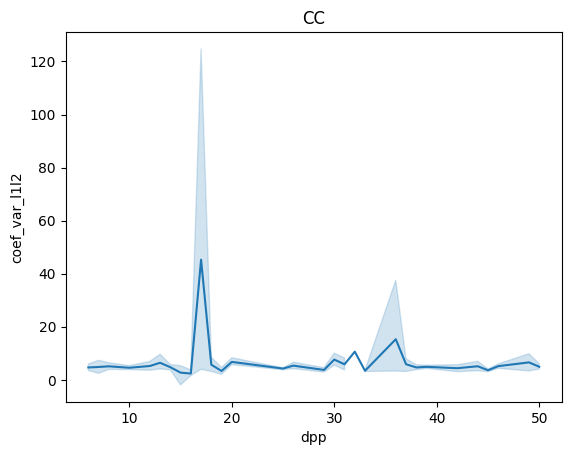

In [62]:
sns.lineplot(data=df.query('condition == "cc"'), x='dpp', y='coef_var_l1l2')
plt.title('CC')

Text(0.5, 1.0, 'con')

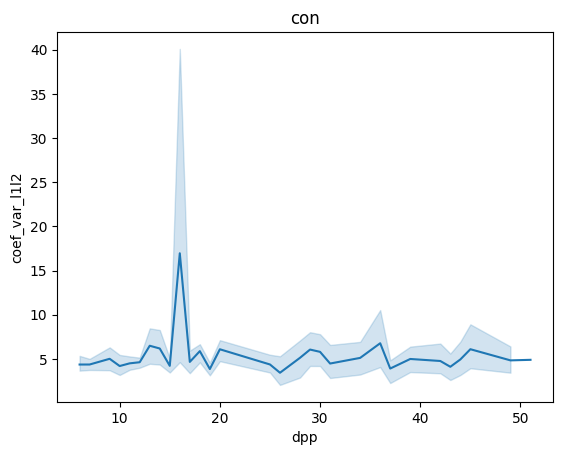

In [63]:
sns.lineplot(data=df.query('condition == "con"'), x='dpp', y='coef_var_l1l2')
plt.title('con')

<Axes: xlabel='dpp', ylabel='std_l1l2'>

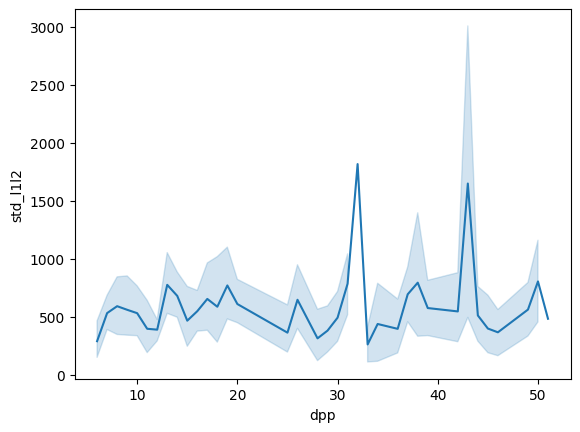

In [64]:
sns.lineplot(data=df, x='dpp', y='std_l1l2')

Text(0.5, 1.0, 'con')

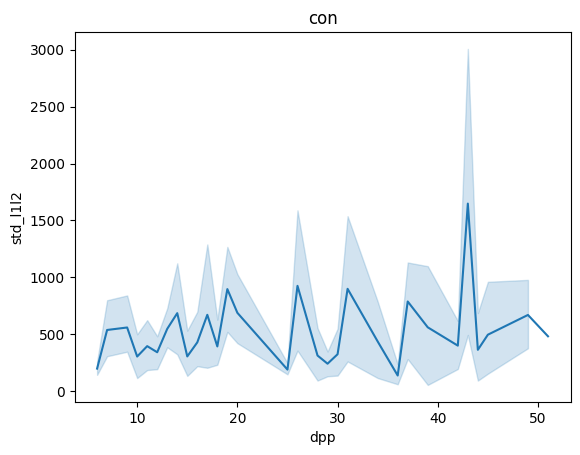

In [65]:
sns.lineplot(data=df.query('condition == "con"'), x='dpp', y='std_l1l2')
plt.title('con')

Text(0.5, 1.0, 'cc')

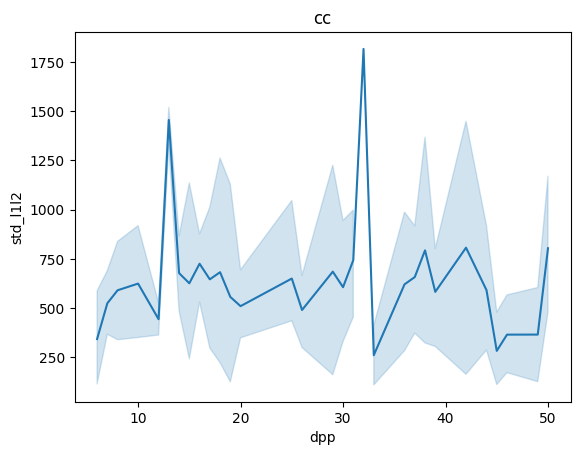

In [66]:
sns.lineplot(data=df.query('condition == "cc"'), x='dpp', y='std_l1l2')
plt.title('cc')

(0.0, 1000.0)

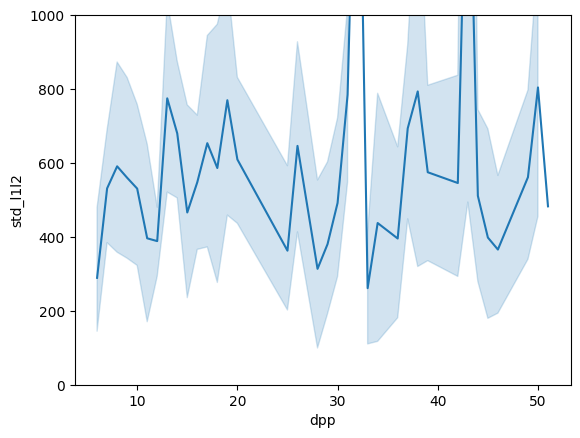

In [67]:
sns.lineplot(data=df, x='dpp', y='std_l1l2')
plt.ylim(0, 1000)

# Predictions

In [68]:
data_dmatrix_mine = xgb.DMatrix(data=df_subset[l1 + l2], label=df_subset['label_cond'])

In [69]:
data_dmatrix_kenny = xgb.DMatrix(data=sub_normalised, label=df_label['condition'])

In [70]:
scores_mine = xgb.cv(dtrain=data_dmatrix_mine, params=params)#,  stratified=True)
scores_mine

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.937523       0.009597       0.641631      0.020288
1        0.985820       0.003626       0.617664      0.042992
2        0.993037       0.000251       0.620261      0.032643
3        0.997567       0.000213       0.625455      0.034467
4        0.999006       0.000613       0.620852      0.038026
5        0.999587       0.000309       0.612862      0.027974
6        0.999752       0.000203       0.608988      0.018331
7        0.999752       0.000268       0.597159      0.022619
8        0.999876       0.000101       0.598637      0.028347
9        0.999917       0.000058       0.604286      0.026506

In [71]:
scores_kenny = xgb.cv(dtrain=data_dmatrix_kenny, params=params)#, stratified=True)
scores_kenny

train-auc-mean  train-auc-std  test-auc-mean  test-auc-std
0        0.909739       0.061368       0.537608      0.166255
1        0.979117       0.017999       0.580087      0.232675
2        0.983902       0.020790       0.506223      0.174881
3        0.997608       0.003383       0.551136      0.172899
4        0.996511       0.002494       0.505141      0.173841
5        0.998405       0.002256       0.484037      0.189970
6        1.000000       0.000000       0.506764      0.221835
7        1.000000       0.000000       0.505141      0.208101
8        1.000000       0.000000       0.487013      0.205907
9        1.000000       0.000000       0.498918      0.201095

Text(0.5, 1.0, 'XGBoost on the 2 datasets (train)')

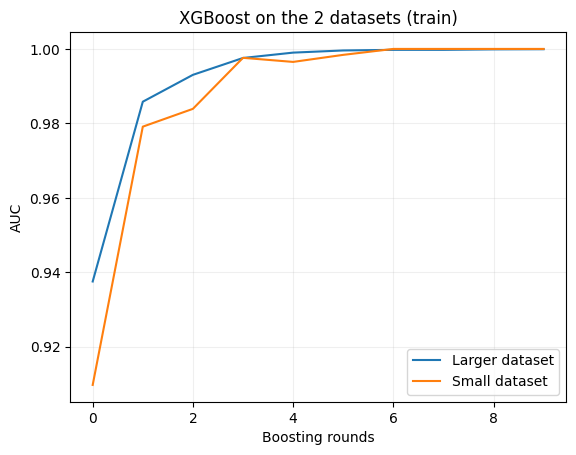

In [72]:
metric = 'test-logloss-mean'

plt.plot(scores_mine['train-auc-mean'], label='Larger dataset')
plt.plot(scores_kenny['train-auc-mean'], label='Small dataset')
plt.legend()
plt.grid(alpha=0.2)
plt.ylabel('AUC')
plt.xlabel('Boosting rounds')
plt.title('XGBoost on the 2 datasets (train)')

Text(0.5, 1.0, 'XGBoost on the 2 datasets (test)')

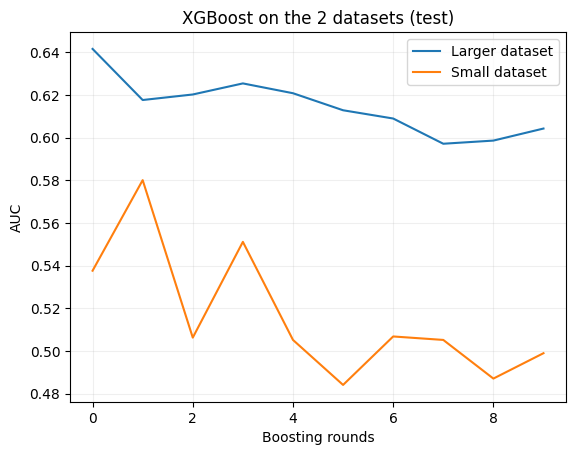

In [73]:

plt.plot(scores_mine['test-auc-mean'], label='Larger dataset')
plt.plot(scores_kenny['test-auc-mean'], label='Small dataset')
plt.legend()
plt.grid(alpha=0.2)
plt.ylabel('AUC')
plt.xlabel('Boosting rounds')
plt.title('XGBoost on the 2 datasets (test)')

In [74]:
xgb_model.fit(df_subset[l1 + l2], df_subset['label_cond'])

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=2, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

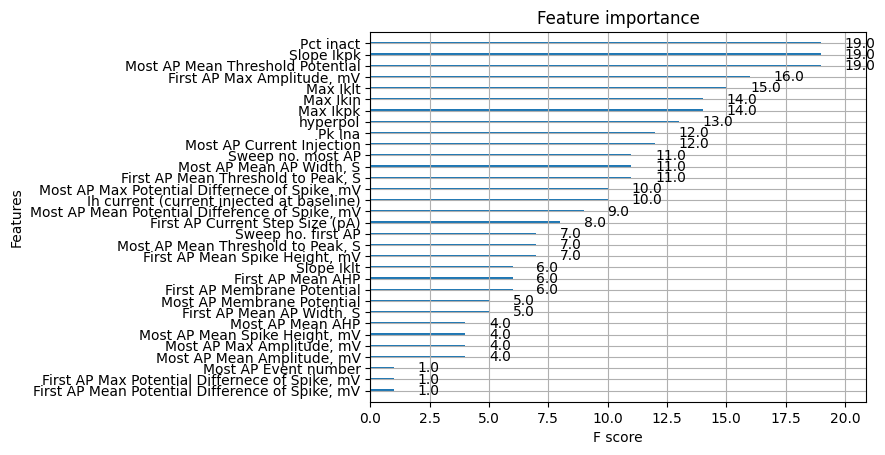

In [75]:
plot_importance(xgb_model)

In [76]:
cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy').mean()

0.550909090909091

In [77]:
cross_val_score(xgb_model, df_subset[l1 + l2], df_subset['label_cond'], cv=5, scoring='accuracy').mean()

0.5740740740740742

In [78]:
randomforest = RandomForestClassifier(random_state=0,class_weight='balanced')

In [79]:
cross_val_score(randomforest, X_train, y_train, cv=5, scoring='accuracy').mean()

0.5854545454545454

# New data plotting

In [80]:
pd.set_option('display.max_columns', None) 

In [81]:
df2 = pd.read_csv('Balazs_Varga/ephys_data/Global dataset with epsps_APs_040823BV_ready.csv', sep='\t')

In [82]:
cc_list = [i for i in df2[~df2['Individual Peaks (pA)'].isna()].query('TTX == 0 & condition == "cc"')['Individual Peaks (pA)'].values if isinstance(i, str)]

In [83]:
cc_list[0].split(',')

['-1528.41', ' -755.905', ' -540.636', ' -416.209', ' -416.966', ' -400.995']

In [84]:
cc_list = [list(i.split(',')) for i in df2[~df2['Individual Peaks (pA)'].isna()].query('TTX == 0 & condition == "cc"')['Individual Peaks (pA)'].values if isinstance(i, str) and i != '']
con_list = [list(i.split(',')) for i in df2[~df2['Individual Peaks (pA)'].isna()].query('TTX == 0 & condition == "con"')['Individual Peaks (pA)'].values if isinstance(i, str) and i != '']

In [85]:
cc_list = [i for j in cc_list for i in j]
con_list = [i for j in con_list for i in j]

In [86]:
cc_list = list(map(float, cc_list))
con_list2 = []
for i in con_list:
    try:
        con_list2.append(float(i))
    except:
        pass


In [87]:
con_list = con_list2
bin_size = 2
con_list = [i for i in con_list if i > -5000]

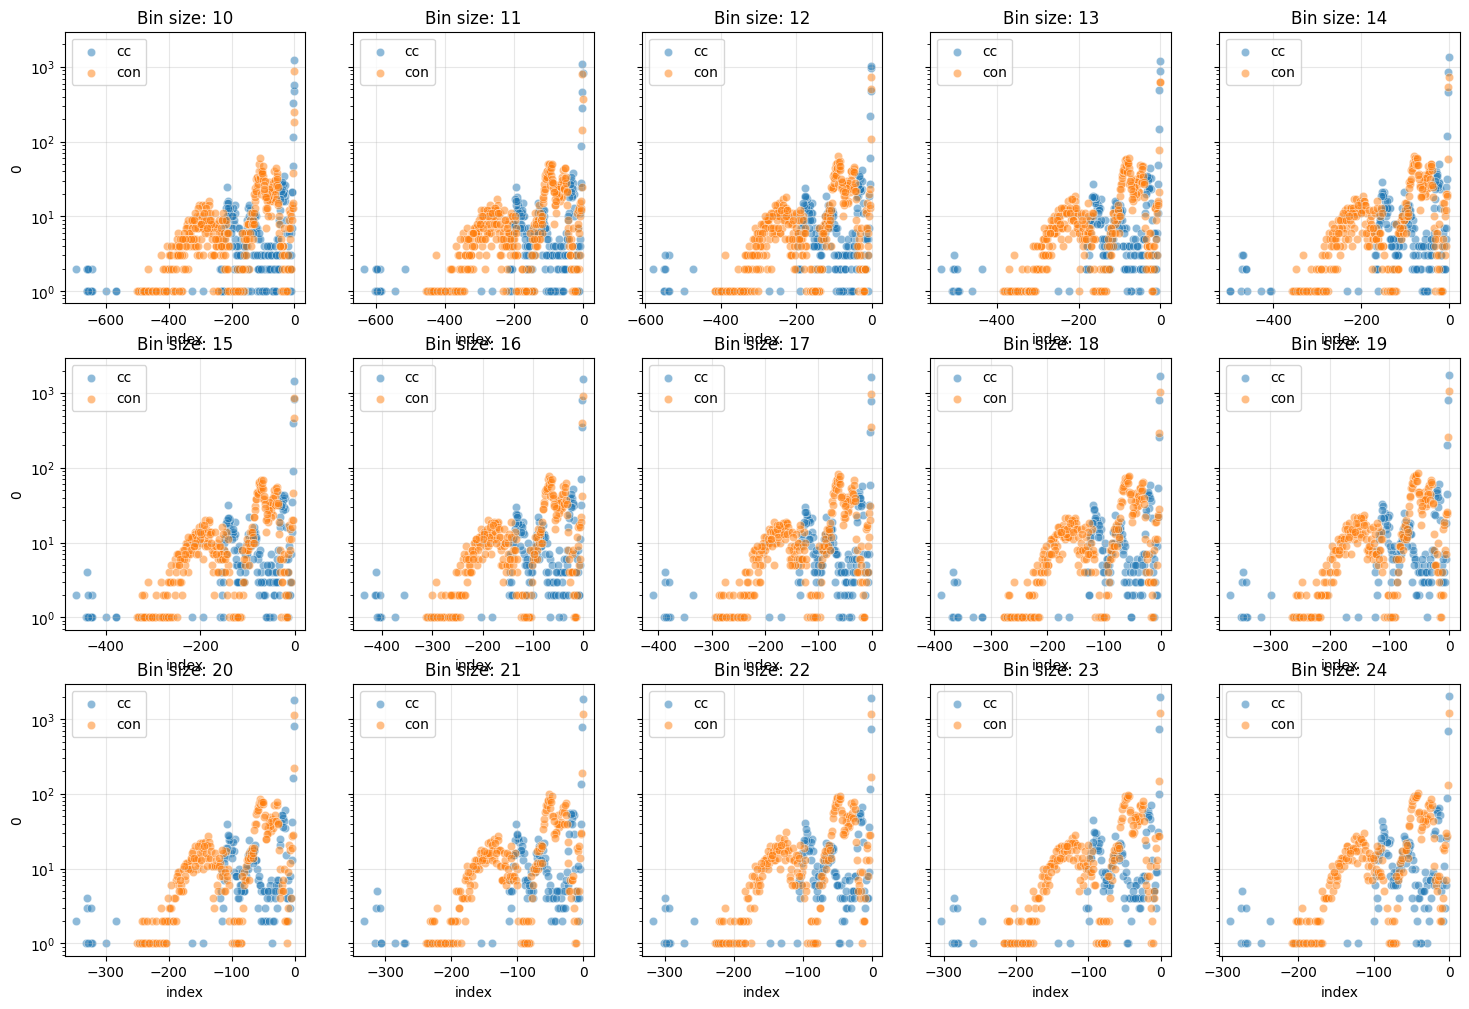

In [89]:
fig, axes = plt.subplots(nrows=3, ncols=5, figsize=(18, 12), sharex=False, sharey=True)
for bin_size in range(15):
    row = bin_size // 5
    col = bin_size % 5
    bin_size += 10
    ax = axes[row][col]
    cc_list_binned = [i // bin_size for i in cc_list]
    con_list_binned = [i // bin_size for i in con_list]
    cc_df = pd.DataFrame.from_dict(dict(Counter(cc_list_binned)), orient='index').reset_index()
    con_df = pd.DataFrame.from_dict(dict(Counter(con_list_binned)), orient='index').reset_index()
    sns.scatterplot(data=cc_df, x='index', y=0, label='cc', ax=ax, alpha=0.5)
    sns.scatterplot(data=con_df, x='index', y=0, label='con', ax=ax, alpha=0.5)
    ax.set_yscale('log')
    ax.set_title('Bin size: {}'.format(bin_size))
    ax.grid(alpha=0.3)

In [90]:
sum(~df2.query('TTX == 0')['Peak, pA'].isna())

152

(array([  23.,   28.,  131.,  314.,  387.,  208.,   76., 1036., 1147.,
        1573.]),
 array([-208. , -187.3, -166.6, -145.9, -125.2, -104.5,  -83.8,  -63.1,
         -42.4,  -21.7,   -1. ]),
 <BarContainer object of 10 artists>)

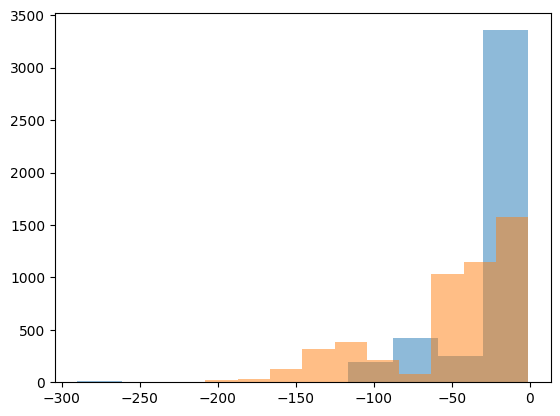

In [91]:
plt.hist(cc_list_binned, alpha=0.5)
plt.hist(con_list_binned, alpha=0.5)